[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ishandandekar/Looking-Fruit/blob/main/Looking_Fruit_nbk.ipynb)

# Looking_Fruit

👋 Hello and welcome to the **Looking_Fruit** notebook. In this notebook I try to replicate the [Fruits-360](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning) research paper. In this paper, researchers have tried to classify images of **131** fruits and vegetables. The data used for these modelling experiments is provided by the paper researchers themselves.

In [1]:
# Check for GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Step 0: Defining the problem


**Objective:**  
To classify the images of various fruits and vegetables with best f1-score.  

**Files:**
- *Train*: This folder contains folders labelled as fruit's/vegetable's name. These subfolders contain images of the respective fruit/vegetable. This folder will be used for training purpose.
- *Test*: This folder contains folders labelled as fruit's/vegetable's name. These subfolders contain images of the respective fruit/vegetable. This folder will be used for testing purpose.

## Step 1: Getting the data
The data used for this project is publicly available on [Kaggle](https://www.kaggle.com/datasets/ishandandekar/fruitimagedataset).

- Use Kaggle's API to download the data into Colab.
- Get utility functions to help in future.
- Configure data files to read using Python.


In [2]:
# Getting the helper functions script
!wget https://raw.githubusercontent.com/ishandandekar/Looking-Fruit/main/helper_functions.py

# Get the necessary functions from the python script
from helper_functions import plot_loss_curves, unzip_data, create_model_checkpoint

--2022-09-04 06:53:05--  https://raw.githubusercontent.com/ishandandekar/Looking-Fruit/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1215 (1.2K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   1.19K  --.-KB/s    in 0s      

2022-09-04 06:53:05 (43.2 MB/s) - ‘helper_functions.py’ saved [1215/1215]



About these helper functions (see documentation for better description):
* **plot_loss_curves** : Plots a line graph (using matplotlib) to see changes in loss and accuracy during training.
* **unzip_data** : Unzips a zip file to a directory
* **create_model_checkpoint** : Create a model checkpoint with only best weights (monitored over validation loss).

In [3]:
# Install the kaggle library
!pip install -q kaggle

# Upload the Kaggle API keys
from google.colab import files
files.upload()

!mkdir ~/.kaggle

# Copy the json file to the folder
!cp kaggle.json ~/.kaggle

# Change permissions for json to work with the Kaggle API
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d ishandandekar/fruitimagedataset

# Unzip data
unzip_data('fruitimagedataset.zip', data_dir="raw")

Saving kaggle.json to kaggle.json
 97% 385M/398M [00:04<00:00, 111MB/s]
100% 398M/398M [00:04<00:00, 99.7MB/s]


## Step 2: Know more about the data

- Get the statistics about the data.
- Check if the labels are imbalanced.
- Visualize random samples in data.
- (*If required*) Trim data.
- (*If required*) Preprocess the data.
- Make data processing faster using `ImageDataGenerator`.

In [4]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [5]:
# Setting up necessary variables
TRAIN_PATH = '/content/raw/train/train/'
TEST_PATH = '/content/raw/test/test/'
RAW_DATA_PATH = '/content/raw'

In [6]:
# Checking the number of classes
classes = []

for dirname, _, filenames in os.walk(RAW_DATA_PATH):
    if dirname.startswith(f"{TRAIN_PATH}"):
        classes.append(dirname[len(TRAIN_PATH):])

print(f"Total number of classes to deal with: {len(classes)}")

Total number of classes to deal with: 131


In [7]:
# Show random classes present in the dataset
list_of_five_random_labels = random.sample(classes,5)
list_of_five_random_labels

['Pear Kaiser', 'Orange', 'Banana Red', 'Pear', 'Tamarillo']

In [8]:
# Number of images of each fruit/vegetable as a pandas.DataFrame

# List to append the count of images
number_of_images_train = []

for label in classes:
    path = f'{TRAIN_PATH}/{label}'
    count = len(os.listdir(path))
    number_of_images_train.append(count)

train_image_count_df = pd.DataFrame({"Label":classes,"Number of Images":number_of_images_train})

# To view first 10 rows of the dataframe
train_image_count_df.head(10)

,Label,Number of Images
0,Cherry Wax Red,492
1,Apple Braeburn,492
2,Apple Golden 1,480
3,Lemon,492
4,Pear Forelle,702
5,Onion Red,450
6,Cucumber Ripe,392
7,Cherry Rainier,738
8,Kaki,490
9,Pear Red,666


In [9]:
# Label with most number of images
print(f"Label with most number of images:")
print(train_image_count_df.sort_values("Number of Images",ascending=False).head(1))
print(f"Label with least number of images:")
print(train_image_count_df.sort_values("Number of Images",ascending=True).head(1))

Label with most number of images:
         Label  Number of Images
74  Grape Blue               984
Label with least number of images:
          Label  Number of Images
95  Ginger Root               297


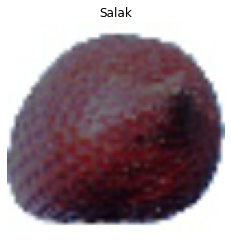

In [10]:
# Show random sample from training of a random fruit/vegetable

random_label = random.choice(classes)
sample_path = f'{TRAIN_PATH}/{random_label}'
random_image= random.choice(os.listdir(sample_path))
random_image_path = f'{sample_path}/{random_image}'

img = mpimg.imread(random_image_path)
imgplot = plt.imshow(img)
plt.axis(False)
plt.title(f'{random_label}')
plt.show()

In [11]:
# Making new directories for trimmed training data
os.mkdir("data")
os.mkdir("data/train")

In [12]:
# Trimming data as there are lot of training examples
# Data will be increased if necessary

# Need around 100 images of each class
TRAIN_IMAGES_COUNT = 100

for label in classes:
  path = f'{TRAIN_PATH}/{label}'
  img_files = os.listdir(path)
  random_count_images = random.sample(img_files, TRAIN_IMAGES_COUNT)
  new_path_for_label = f"/content/data/train/{label}"
  os.mkdir(new_path_for_label)

  for img_file in random_count_images:
    shutil.move(f"{path}/{img_file}", new_path_for_label)

In [15]:
# Creating ImageDataGenerators for better data processing

# Image size has been specified in the research paper
IMAGE_SIZE = (100,100)
BATCH_SIZE = 32
TRIMMED_TRAIN_PATH = '/content/data/train'

train_datagen = ImageDataGenerator(width_shift_range=0,
                                   height_shift_range=0,
                                   zoom_range=0,
                                   horizontal_flip=0,
                                   vertical_flip=0)

# Need the test data as is, but need to make it process faster
test_datagen = ImageDataGenerator()

train_data = train_datagen.flow_from_directory(TRIMMED_TRAIN_PATH,
                                              target_size=IMAGE_SIZE,
                                              class_mode='sparse',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              classes=classes)

test_data = test_datagen.flow_from_directory(TEST_PATH,
                                            target_size=IMAGE_SIZE,
                                            class_mode='sparse',
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            classes=classes)

Found 13100 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


## Step 3: Describing modelling experiments

- This notebook contains 7 models built to get the best **f1-score** on the test dataset. These models also include the models made by the researchers themselves.  
- Models to be made:
  1. **Model 0** : A simple model with fully connected multiple Dense layers; this model acts as a baseline.
  1. **Model 1** : 2 pairs of CNN and MaxPool layers with a Flatten layer and Dense layer in the end for classification.
  1. **Model 2** : Multiple CNN layers, MaxPool layers with a Flatten layer and Dense layer in the end; *should get better results from this.*
  1. **Model 3** : Using transfer learning, exploit ResNet model for classification.
  1. **Model 4** : Using transfer learning, exploit EfficientNetBx for classification.
  1. **Model 5** : Use fine-tuned ResNet model for classification.
  1. **Model 6** : Use fine-tuned EfficientNetBx for classification.
- Get classification metrics for each model.


### Model 0 
* **Layers:** 3 Dense layers
* **Optimizer:** Adam
* **Loss:** Cross entropy
* **Epochs:** 5
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

In [ ]:
# 0. Set random seed
tf.random.set_seed(42)

# 1. Create the model
model_0 = tf.keras.Sequential([
    layers.InputLayer(input_shape=IMAGE_SIZE+(3)),
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(131, activation="softmax")
], name="model_0_dense")

# 2. Compile the model
model_0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer="Adam",
                metrics=["accuracy"])

# 3. Fit the model
history_model_0 = model_0.fit(train_data,
                              epochs=5,
                              validation_data=test_data,
                              callbacks=[create_model_checkpoint(model_name=model_0.name)])

In [ ]:
# Loading in the best weights
best_weigths_path = "/content/model_experiments/model_0_dense/"
model_0.load_weights(best_weights_path)

# Evaluate on test set
model_0.evaluate(test_data)

In [ ]:
# Unravel dataset
y_labels = []
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [ ]:
# Getting predictions on test data
model_0_preds_prob = model_0.predict(test_data, verbose=1)
model_0_preds_classes = model_0_preds_prob.argmax(axis=1)

# Getting classification report
from sklearn.metrics import classification_report
print(classification_report(y_labels,pred_classes))

### Model 1 
* **Layers:** 3 Dense layers
* **Optimizer:** Adam
* **Loss:** Cross entropy
* **Epochs:** 5
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

### Model 2 
* **Layers:** 3 Dense layers
* **Optimizer:** Adam
* **Loss:** Cross entropy
* **Epochs:** 5
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

### Model 3
* **Layers:** 3 Dense layers
* **Optimizer:** Adam
* **Loss:** Cross entropy
* **Epochs:** 5
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

### Model 4 
* **Layers:** 3 Dense layers
* **Optimizer:** Adam
* **Loss:** Cross entropy
* **Epochs:** 5
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

### Model 5
* **Layers:** 3 Dense layers
* **Optimizer:** Adam
* **Loss:** Cross entropy
* **Epochs:** 5
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

### Model 6
* **Layers:** 3 Dense layers
* **Optimizer:** Adam
* **Loss:** Cross entropy
* **Epochs:** 5
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

## Step 4: Compare results and conclude experiments
- Test each model on the given test dataset.
- Use graphs and matrices to visualize results.
- (*Optional*) Tune hyperparameters of the best model.
- Compare best models results with researchers best model.
- Export the best model.
